# Trigger files
This notebook is intended to create the descriptive, streams information and timestamps as '.csv' files, and trigger files.
- Descriptive files contain information about the recordings such as duration, sampling rate, names of streams collected, type, etc.
- Stream information files contain all data gathered during recording with respective timestamps (e.g., head and eye tracking, object names)
- The trigger files contain information about the time when an image was shown, the type of image, distance, rotation and block. These files are required to set the stimulus onset during the eeg data analysis.

In [1]:
import copy
import datetime
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

import pandas as pd
import pyxdf
import dataframe_image as dfi
import seaborn as sns
from scipy.signal import find_peaks
from operator import itemgetter
from tqdm.notebook import tqdm


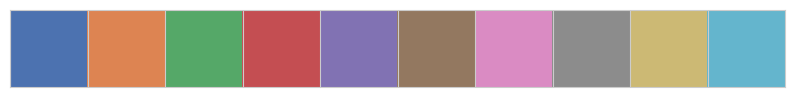

In [2]:
# choosing the color palette
deep_pal = sns.color_palette('deep')
sns.palplot(deep_pal)
sns.set_style("white")

In [3]:
# path to data stored
r_path = "data"
# path to store trigger data
t_path = r_path + '/triggers'
# path to store eye-tracking data
e_path = r_path + '/eye_tracking'

# Get some quick idea abou the files
files = os.listdir(r_path)  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = {}
file_names = []
for i, file in enumerate(files):  # store and display all files
    if file.endswith('.xdf'):
        file_names.append(file)
        created = os.path.getmtime(f"data/{file}")  # creation timestamp
        created = datetime.datetime.fromtimestamp(created)  # translate as datetime
        created = created.strftime("%d.%m.%Y %H:%M")  # arrange it
        recordings[i] = {"file": file, "created": created}
# print(file_names)
files = [f.split(".")[0] for f in files]
print("Included:")
display(recordings)

Included:


{1: {'file': '01_room1_pilot1.xdf', 'created': '14.10.2022 21:32'},
 2: {'file': '39_room1_251022.xdf', 'created': '25.10.2022 16:40'},
 3: {'file': '40_room1_261022.xdf', 'created': '26.10.2022 16:54'}}

## 1. Load data

In [4]:
# check streams for recording 0
file_to_use = file_names[1]
streams, _ = pyxdf.load_xdf(f"data/{file_to_use}")

In [5]:
# stream channel names in recording 0
s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
s_channels
# Get an idea of stream 'ImageInfo'
# streams[7]
# streams[7]['info']
# streams[7]['time_series']
# streams[7]['time_stamps']
# length of time_stamps
# len(streams[2]['time_stamps'])
# print all source_ids in stream 7
# source_ids = [i['info']['source_id'] for i in streams]
# source_ids

{'ImagesOrder': 0,
 'ValidationError': 1,
 'HeadTracking': 2,
 'openvibeSignal': 3,
 'EyeTrackingLocal': 4,
 'EyeTrackingWorld': 5,
 'HitObjectPositions': 6,
 'ImageInfo': 7,
 'Visual': 8,
 'HitObjectNames': 9,
 'HitPositionOnObjects': 10}

In [6]:
streams[3]['time_stamps'][0:550] - streams[3]['time_stamps'][0]

array([0.        , 0.00097656, 0.00195312, 0.00292969, 0.00390625,
       0.00488281, 0.00585938, 0.00683594, 0.0078125 , 0.00878906,
       0.00976562, 0.01074219, 0.01171875, 0.01269531, 0.01367188,
       0.01464844, 0.015625  , 0.01660156, 0.01757812, 0.01855469,
       0.01953125, 0.02050781, 0.02148438, 0.02246094, 0.0234375 ,
       0.02441406, 0.02539062, 0.02636719, 0.02734375, 0.02832031,
       0.02929688, 0.03027344, 0.03125   , 0.03222656, 0.03320312,
       0.03417969, 0.03515625, 0.03613281, 0.03710938, 0.03808594,
       0.0390625 , 0.04003906, 0.04101562, 0.04199219, 0.04296875,
       0.04394531, 0.04492188, 0.04589844, 0.046875  , 0.04785156,
       0.04882812, 0.04980469, 0.05078125, 0.05175781, 0.05273438,
       0.05371094, 0.0546875 , 0.05566406, 0.05664062, 0.05761719,
       0.05859375, 0.05957031, 0.06054688, 0.06152344, 0.0625    ,
       0.06347656, 0.06445312, 0.06542969, 0.06640625, 0.06738281,
       0.06835938, 0.06933594, 0.0703125 , 0.07128906, 0.07226

In [7]:
df_eeg = pd.DataFrame(streams[3]['time_series'][0:6144,0:10]).rename(columns={0: "Ch1", 1: "Ch2", 2: "Ch3",3: "Ch4", 4: "Ch5",5: "Ch6", 6: "Ch7", 7: "Ch8",8: "Ch9", 9: "Ch10"})
df_eeg['timestamps'] = streams[3]['time_stamps'][0:6144] - streams[3]['time_stamps'][0]
df_eeg

,Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Ch9,Ch10,timestamps
0,-2668.076416,1270.013428,-1223.541870,-8322.321289,-5491.033203,-2232.895508,-931.729370,-2979.970703,-4271.408691,-3330.484131,0.000000
1,-2667.653320,1271.079956,-1221.040771,-8319.837891,-5491.217285,-2232.803467,-931.582214,-2979.566162,-4271.812988,-3329.932373,0.000977
2,-2668.315430,1269.608765,-1218.870850,-8319.654297,-5495.722656,-2233.281494,-932.832764,-2980.209717,-4269.072754,-3329.399170,0.001953
3,-2672.342773,1270.013428,-1214.181396,-8317.465820,-5499.970703,-2233.851562,-935.352173,-2979.639648,-4267.822266,-3330.079590,0.002930
4,-2675.174805,1271.171997,-1203.239258,-8318.385742,-5503.170898,-2232.288574,-933.531555,-2982.048828,-4271.150879,-3331.127686,0.003906
...,...,...,...,...,...,...,...,...,...,...,...
6139,-2682.549316,1262.841309,-1207.046021,-8332.306641,-5509.404785,-2256.434570,-953.006592,-2994.314941,-4290.865234,-3350.565918,5.995117
6140,-2683.634277,1265.011353,-1206.512695,-8329.437500,-5505.745117,-2254.282959,-950.395203,-2992.218506,-4290.276855,-3349.315430,5.996094
6141,-2689.445557,1262.730957,-1208.259766,-8328.812500,-5505.653320,-2255.000244,-950.891724,-2991.574951,-4286.433105,-3347.550049,5.997070
6142,-2699.780762,1260.266724,-1212.985962,-8329.418945,-5507.455566,-2254.760986,-952.436462,-2994.498779,-4286.469727,-3345.563965,5.998047


In [8]:
for i, value in enumerate(df_eeg.columns[0:5]):
    print(value)

Ch1
Ch2
Ch3
Ch4
Ch5


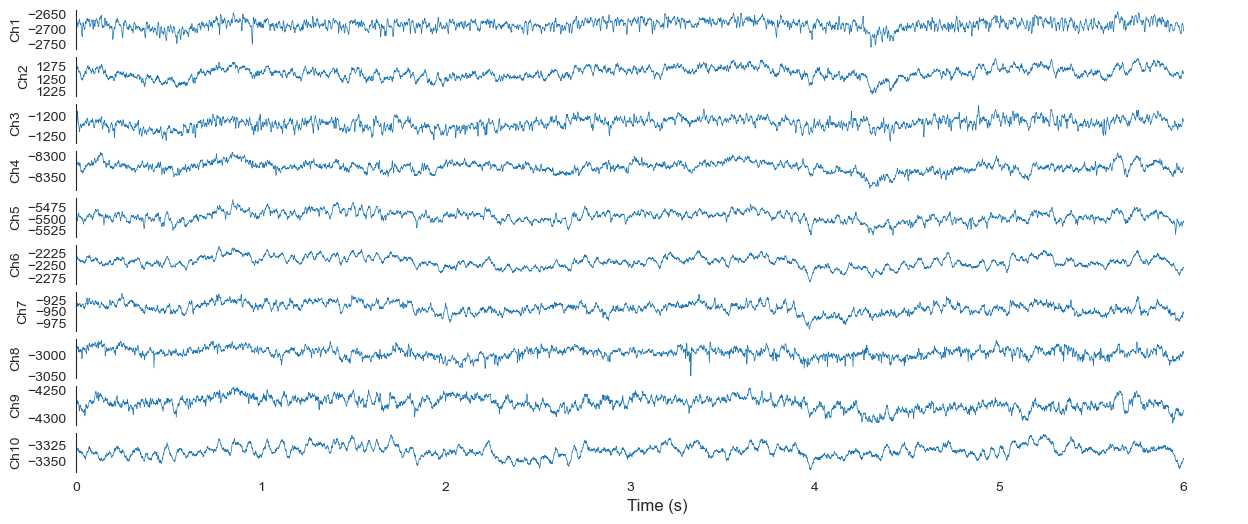

In [52]:
fig, ax = plt.subplots(nrows=10, figsize=(15, 6), sharex=True)
plt.rcParams.update({'font.size': 10})
for i, value in enumerate(df_eeg.columns[0:10]):
    sns.lineplot(x= df_eeg['timestamps'], y = df_eeg[value], ax=ax[i], linewidth=0.5)
    ax[i].set_xlim(0,None)
    ax[i].set_xlabel('Time (s)', fontsize=12)
    sns.despine(top=True, bottom=True)
plt.savefig("data/images/" + "eeg_6seconds" + ".pdf", format='pdf', dpi=1200)


In [10]:
def describe_recordings(streams, file_name=''):
    ch_keys = ["name","type", "channel_count","channel_format","nominal_srate","desc","effective_srate","hostname", "created_at"]
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}

    for i, ch_name in enumerate(s_channels):
        if ch_name in 'openvibeSignal':
            # save uid and append to csv
            uid = streams[i]['info']['uid'][0]
            # calculate the recording duration based on first and last time_stamps
            duration = (streams[i]['time_stamps'][-1]- streams[i]['time_stamps'][0])/60
        if ch_name in 'Visual':
            # calculate the duration for the 1st unity half block
            block_1_duration  = (streams[i]['time_stamps'][30000] - streams[i]['time_stamps'][0])/60
            # Unity sampling rate (fps) for 1rst half block
            fps = 1 / (block_1_duration * 60 / 30000)

    df = pd.DataFrame(columns=np.concatenate([['uid','file_name','duration (min)','unity_fps','stream_id'], ch_keys]))
    id_o = []
    for id, stream in enumerate(streams):
        id_o.append(id)
        items = itemgetter(*ch_keys)(dict(stream['info']))
        items = [(', '.join(list(item[0].keys())) if 'desc' in ch_keys[i] else (
                  item[0] if isinstance(item, list) else item)) for i, item in enumerate(items)]
        df = df.append(pd.Series(items, index=ch_keys), ignore_index=True)

    df['uid'] = np.resize(uid,len(streams))
    df['file_name'] = np.resize(file_name,len(streams))
    df['duration (min)'] = np.resize(duration,len(streams))
    df['unity_fps'] = np.resize(fps,len(streams))
    df['stream_id'] = id_o

    return df

In [11]:
desc_streams = describe_recordings(streams, file_name=file_to_use)
# dfi.export(desc_streams,'data/description.png')
desc_streams

,uid,file_name,duration (min),unity_fps,stream_id,name,type,channel_count,channel_format,nominal_srate,desc,effective_srate,hostname,created_at
0,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,0,ImagesOrder,Markers,2,string,0.000000000000000,"arrayOfImages, orderOfImageIndexesToDisplay",0,ml03,94431.13724850000
1,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,1,ValidationError,Markers,3,float32,0.000000000000000,"ValX, ValY, ValZ",0,ml03,94431.12355180000
2,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,2,HeadTracking,Markers,6,float32,0.000000000000000,"HToriginX, HToriginY, HToriginZ, HTdirectionX,...",0,ml03,94431.12808569999
3,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,3,openvibeSignal,signal,72,float32,1024.000000000000,channels,1024.000001,wd-left,933819.4845182000
4,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,4,EyeTrackingLocal,Markers,6,float32,0.000000000000000,"ETLoriginX, ETLoriginY, ETLoriginZ, ETLdirecti...",0,ml03,94431.12671400000
5,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,5,EyeTrackingWorld,Markers,10,float32,0.000000000000000,"ETWTime, ETWoriginX, ETWoriginY, ETWoriginZ, E...",0,ml03,94431.12521860001
6,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,6,HitObjectPositions,Markers,3,float32,0.000000000000000,"HOPX, HOPY, HOPZ",0,ml03,94431.13115430000
7,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,7,ImageInfo,Markers,2,string,0.000000000000000,"blockNumber, imageName",0,ml03,94431.13559799999
8,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,8,Visual,Markers,3,float32,0.000000000000000,"cFrame, displayStatus, worldTime",0,ml03,94431.13407309999
9,2afa150a-914a-4afd-95f3-e7c065ffc4f1,39_room1_251022.xdf,61.906755,90.00127,9,HitObjectNames,Markers,1,string,0.000000000000000,HON,0,ml03,94431.12957840000


In [12]:
# 3730.732377192173
# 3730.73246817
ref_ts = (streams[8]['time_stamps'][-1] - streams[3]['time_stamps'][0]) / 60
ref_ts
# eeg_ts1 = float(ref_ts) -1
# eeg_ts1

61.69006174184809

## 2. Create dataframe from streams

In [13]:
def get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal'):
    """
    :param streams: streams after loading from .xdf file
    :param streams_keep: str. of the stream names to keep
    :param time_ref_stream: str. name of the eeg  signal used used for time correction and uid creation
    :return: df containing the time_stamps and stream_data as columns for each stream to keep
    """
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
    eeg_u = s_channels[time_ref_stream]
    eeg_first_ts = float(streams[eeg_u]['time_stamps'][0])
    eeg_all_ts = streams[eeg_u]['time_stamps'] # all eeg timestamps
    uid = streams[eeg_u]['info']['uid'][0]

    data = pd.DataFrame()
    for i, ch_name in enumerate(streams_keep):
        # get all current streams with their positions on the recording
        # example: {'ImagesOrder': 0, 'ValidationError': 1, 'HeadTracking': 2}
        s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}
        u = s_channels[ch_name]
        # save the recording UID and append to df
        data['uid'] = np.resize(uid,len(data))

        # check the type and length of data arrays and get only 1 value of the array
        stream_data = streams[u]['time_series']
        # double check keys on each stream to make sure they are all appended to df
        # print(f"Stream {ch_name} keys: {streams[u]['info']['desc'][0].keys()}")
        # check stram_data is of kind np.array()
        if isinstance(stream_data, (list,pd.core.series.Series,np.ndarray)):
            # access all stream names in dictionary's 'info' description
            for i, key in enumerate(streams[u]['info']['desc'][0].keys()):
                # save each dict key as column to df
                stream_data = pd.DataFrame(streams[u]['time_series'])[i]
                data[f"{key}_{ch_name}"] = stream_data


        # get timestamps and attach them as column to df
        time_stamps =  streams[u]['time_stamps']
        data = pd.concat([data, pd.DataFrame(time_stamps, columns=[f"time_stamps_{ch_name}"])], axis=1)
        # save timestamps after normalising them to zero
        data[f"corrected_tstamps_{ch_name}"] = data[f"time_stamps_{ch_name}"] - eeg_first_ts

    return data

In [14]:
df_img_info = get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal')
df_img_info

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual
0,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,fixationCross,934259.969858,0.269499,3971.0,1.0,99.704880,934259.969854,0.269495
1,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-07-12_00-09-21.hitname...,934259.981103,0.280744,3972.0,0.0,99.716118,934259.981097,0.280738
2,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-07-12_00-09-21.hitname...,934259.991990,0.291631,3973.0,0.0,99.727005,934259.991983,0.291624
3,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-07-12_00-09-21.hitname...,934260.003191,0.302832,3974.0,0.0,99.738205,934260.003185,0.302826
4,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-07-12_00-09-21.hitname...,934260.015160,0.314801,3975.0,0.0,99.750175,934260.015151,0.314792
...,...,...,...,...,...,...,...,...,...,...
301983,2afa150a-914a-4afd-95f3-e7c065ffc4f1,3,endMessage,937961.059559,3701.359200,305840.0,99.0,3800.785645,937961.059551,3701.359192
301984,2afa150a-914a-4afd-95f3-e7c065ffc4f1,3,endMessage,937961.070648,3701.370289,305841.0,99.0,3800.796631,937961.070642,3701.370283
301985,2afa150a-914a-4afd-95f3-e7c065ffc4f1,3,endMessage,937961.081876,3701.381517,305842.0,99.0,3800.807861,937961.081869,3701.381510
301986,2afa150a-914a-4afd-95f3-e7c065ffc4f1,3,endMessage,937961.092953,3701.392594,305843.0,99.0,3800.819092,937961.092945,3701.392586


In [48]:
df_start = df_img_info.head(540)

df_start['displayStatusNames'] = df_start.apply(lambda x: 'image' if 'img' in x['imageName_ImageInfo'].lower()
                                            else ('fixCross' if 'fixation' in x['imageName_ImageInfo'].lower()
                                            else ('grayCanvas' if 'gray' in x['imageName_ImageInfo'].lower()
                                            else '')), axis=1)
df_start

/var/folders/yy/s3wgmwl10fg_cc7cb_s92snr0000gn/T/ipykernel_66558/4214071777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start['displayStatusNames'] = df_start.apply(lambda x: 'image' if 'img' in x['imageName_ImageInfo'].lower()


,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,displayStatusNames
0,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,fixationCross,934259.969858,0.269499,3971.0,1.0,99.704880,934259.969854,0.269495,fixCross
1,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-07-12_00-09-21.hitname...,934259.981103,0.280744,3972.0,0.0,99.716118,934259.981097,0.280738,image
2,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-07-12_00-09-21.hitname...,934259.991990,0.291631,3973.0,0.0,99.727005,934259.991983,0.291624,image
3,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-07-12_00-09-21.hitname...,934260.003191,0.302832,3974.0,0.0,99.738205,934260.003185,0.302826,image
4,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-07-12_00-09-21.hitname...,934260.015160,0.314801,3975.0,0.0,99.750175,934260.015151,0.314792,image
...,...,...,...,...,...,...,...,...,...,...,...
535,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-08-04_21-38-52.hitname...,934265.911483,6.211124,4506.0,0.0,105.646484,934265.911478,6.211119,image
536,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-08-04_21-38-52.hitname...,934265.922480,6.222121,4507.0,0.0,105.657486,934265.922476,6.222117,image
537,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-08-04_21-38-52.hitname...,934265.933658,6.233298,4508.0,0.0,105.668663,934265.933653,6.233294,image
538,2afa150a-914a-4afd-95f3-e7c065ffc4f1,0,img.1600x1000.date.2022-08-04_21-38-52.hitname...,934265.944750,6.244391,4509.0,0.0,105.679756,934265.944746,6.244387,image


KeyError: 'displayStatusNames'

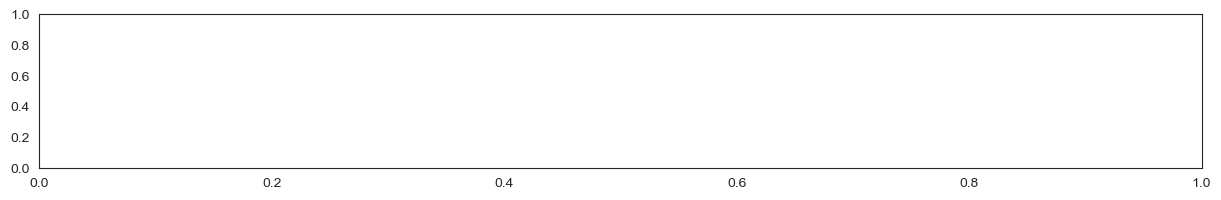

In [49]:
df_start = df_img_info.head(540)
fig, ax = plt.subplots(nrows=1, figsize=(15, 2))
plt.rcParams.update({'font.size': 10})
sns.scatterplot(x=df_start['corrected_tstamps_ImageInfo'], y=df_start['displayStatus_Visual'], data=df_start['displayStatusNames'])
ax.set_xlim(0, 8)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Displaying status', fontsize=12)
sns.despine(top=True)

In [219]:
# quick statistics to know if all rows have same length
df_eeg.describe()
# df['HON_HitObjectNames'].isnull().sum()
# df['HON_HitObjectNames'].unique()

,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual
count,111180.000000,111180.000000,111180.000000,111180.000000,111180.000000,111180.000000,111180.000000
mean,4393.360486,662.628018,59361.429688,1.440394,753.423584,4393.360477,662.628008
std,394.274395,394.274395,32028.070312,1.333862,394.272064,394.274395,394.274395
min,3730.998672,0.266204,3841.000000,0.000000,91.064651,3730.998659,0.266191
25%,4039.835421,309.102953,31648.750000,0.000000,399.900681,4039.835412,309.102943
50%,4381.357276,650.624808,59382.500000,1.000000,741.421722,4381.357267,650.624799
75%,4757.342356,1026.609887,87046.250000,2.000000,1117.405884,4757.342347,1026.609879
max,5066.179362,1335.446894,114854.000000,5.000000,1426.242188,5066.179353,1335.446884


In [223]:
# inspect the eye_tracking data
df_eye = get_streams_data(streams, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'])
df_eye

,uid,HON_HitObjectNames,time_stamps_HitObjectNames,corrected_tstamps_HitObjectNames,HPOOX_HitPositionOnObjects,HPOOY_HitPositionOnObjects,HPOOZ_HitPositionOnObjects,time_stamps_HitPositionOnObjects,corrected_tstamps_HitPositionOnObjects,HToriginX_HeadTracking,...,time_stamps_EyeTrackingWorld,corrected_tstamps_EyeTrackingWorld,ETLoriginX_EyeTrackingLocal,ETLoriginY_EyeTrackingLocal,ETLoriginZ_EyeTrackingLocal,ETLdirectionX_EyeTrackingLocal,ETLdirectionY_EyeTrackingLocal,ETLdirectionZ_EyeTrackingLocal,time_stamps_EyeTrackingLocal,corrected_tstamps_EyeTrackingLocal
0,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,3730.997349,0.264881,0.025130,1.446558,9.418699,3730.997353,0.264885,0.017377,...,3730.997272,0.264803,0.031408,0.001798,-0.025572,0.002686,-0.093506,0.995605,3730.998010,0.265542
1,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,3731.008460,0.275992,0.082237,1.446519,9.423999,3731.008465,0.275996,0.017391,...,3731.008376,0.275908,0.031048,0.001815,-0.025599,0.008621,-0.093369,0.995590,3731.009143,0.276674
2,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,3731.019443,0.286975,0.045631,1.432317,9.416549,3731.019446,0.286978,0.017432,...,3731.019357,0.286889,0.026963,0.001906,-0.025647,0.005142,-0.094482,0.995499,3731.020026,0.287558
3,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,3731.030531,0.298062,0.034770,1.427868,9.414793,3731.030533,0.298065,0.017440,...,3731.030461,0.297993,0.023141,0.001992,-0.025693,0.004288,-0.094803,0.995483,3731.031090,0.298622
4,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,3731.041669,0.309201,0.010570,1.432112,9.414815,3731.041672,0.309203,0.017486,...,3731.041608,0.309140,0.016942,0.002129,-0.025755,0.002258,-0.094482,0.995514,3731.042199,0.309731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100492,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,5066.133986,1335.401517,-0.173868,1.057811,9.479301,5066.133989,1335.401521,0.029180,...,5066.133909,1335.401441,-0.000950,0.003270,-0.027301,0.137268,-0.136169,0.981125,5066.134563,1335.402095
100493,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,5066.144915,1335.412447,-0.170069,1.069861,9.472626,5066.144917,1335.412449,0.029200,...,5066.144838,1335.412370,-0.000823,0.003266,-0.027293,0.137665,-0.135559,0.981155,5066.145489,1335.413020
100494,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,5066.156074,1335.423606,-0.169865,1.070280,9.472397,5066.156075,1335.423607,0.029205,...,5066.156014,1335.423545,-0.000680,0.003261,-0.027286,0.137695,-0.135757,0.981110,5066.156599,1335.424131
100495,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,FixationCollider,5066.167128,1335.434660,-0.171499,1.069171,9.473394,5066.167129,1335.434661,0.029212,...,5066.167067,1335.434599,-0.000224,0.003246,-0.027267,0.137497,-0.136063,0.981110,5066.167650,1335.435181


In [151]:
# df_eye.describe()
df_eye.isnull().sum()

UID                                 0
HON_HitObjectNames                  0
time_stamps_HitObjectNames          0
HPOOX_HitPositionOnObjects          0
HPOOY_HitPositionOnObjects          0
HPOOZ_HitPositionOnObjects          0
time_stamps_HitPositionOnObjects    0
HToriginX_HeadTracking              0
HToriginY_HeadTracking              0
HToriginZ_HeadTracking              0
HTdirectionX_HeadTracking           0
HTdirectionY_HeadTracking           0
HTdirectionZ_HeadTracking           0
time_stamps_HeadTracking            0
ETWTime_EyeTrackingWorld            0
ETWoriginX_EyeTrackingWorld         0
ETWoriginY_EyeTrackingWorld         0
ETWoriginZ_EyeTrackingWorld         0
ETWdirectionX_EyeTrackingWorld      0
ETWdirectionY_EyeTrackingWorld      0
ETWdirectionZ_EyeTrackingWorld      0
leftBlink_EyeTrackingWorld          0
rightBlink_EyeTrackingWorld         0
valid_EyeTrackingWorld              0
time_stamps_EyeTrackingWorld        0
dtype: int64

## 3. Create triggers
- For each initial time an image was shown, we want to keep the type of object it was (i.e., face, object, body) as a separate column.
- Additional triggers contain the rotation and distance the specific object was with respect to the player at the time the free-viewing walk took place.
- __Note:__ We want the triggers only once to denote the initial time the image was shown.

In [224]:
def create_triggers(df):
    # save the names of the object, body or face shown in the image
    df['ob_names'] =  df.apply(lambda x: x["imageName_ImageInfo"].split(".")[5] if len(x["imageName_ImageInfo"].split(".")) > 7 else '', axis=1)
    # create the triggers to mark the start of image displaying
    # check when there is a change from image, canvas, fixationCross
    df['shift'] = df['imageName_ImageInfo'].shift(1) != df['imageName_ImageInfo']
    # save the starting time (aka 'latency') when image is displayed
    df['latency'] = df.apply(lambda x: x['corrected_tstamps_Visual'] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    # save the type of image displaying (face, object, body)
    df['type'] = df.apply(lambda x: 'face' if x['shift'] and 'face' in x['imageName_ImageInfo'].lower()
                                            else ('body' if x['shift'] and 'npc' in x['imageName_ImageInfo'].lower()
                                            else ('object' if x['shift'] and 'rotation' in x['imageName_ImageInfo'].lower()
                                            and 'face|npc' not in x['imageName_ImageInfo'].lower()
                                            else '')), axis=1)
    # define the triggers for rotation, distance, and block
    df['rotation'] = df.apply(lambda x: 'r_' + x["imageName_ImageInfo"].split(".")[7] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    df['distance'] = df.apply(lambda x: 'd_' + x["imageName_ImageInfo"].split(".")[9] if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    df['block'] = df.apply(lambda x: 'b_' + str(x["blockNumber_ImageInfo"]) if len(x["imageName_ImageInfo"].split(".")) > 7 and x['shift'] else '', axis=1)
    # select the trigger columns and non empty rows
    df_sel = df[['latency','type','rotation','distance','block']]
    df_triggers = df_sel[df_sel['latency'] != '']
    # save first uid for later usage
    uid = df['uid'][0]
    return df, df_triggers, uid

In [225]:
df, df_triggers, uid = create_triggers(df)
df

,uid,blockNumber_ImageInfo,imageName_ImageInfo,time_stamps_ImageInfo,corrected_tstamps_ImageInfo,cFrame_Visual,displayStatus_Visual,worldTime_Visual,time_stamps_Visual,corrected_tstamps_Visual,ob_names,shift,latency,type,rotation,distance,block
0,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,0,grayCanvas,3730.998672,0.266204,3841.0,2.0,91.064651,3730.998659,0.266191,,True,,,,,
1,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,0,grayCanvas,3731.009716,0.277248,3842.0,2.0,91.075706,3731.009707,0.277238,,False,,,,,
2,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,0,grayCanvas,3731.020642,0.288174,3843.0,2.0,91.086632,3731.020630,0.288162,,False,,,,,
3,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,0,grayCanvas,3731.031608,0.299140,3844.0,2.0,91.097603,3731.031599,0.299130,,False,,,,,
4,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,0,grayCanvas,3731.042741,0.310273,3845.0,2.0,91.108734,3731.042731,0.310263,,False,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111175,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,1,img.1600x1000.date.2022-10-07_17-31-45.hitname...,5066.135132,1335.402663,114850.0,0.0,1426.197998,5066.135121,1335.402653,face_416,False,,,,,
111176,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,1,img.1600x1000.date.2022-10-07_17-31-45.hitname...,5066.146061,1335.413592,114851.0,0.0,1426.208862,5066.146050,1335.413581,face_416,False,,,,,
111177,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,1,img.1600x1000.date.2022-10-07_17-31-45.hitname...,5066.157166,1335.424698,114852.0,0.0,1426.219971,5066.157156,1335.424688,face_416,False,,,,,
111178,e0e948a0-f7fb-4f02-af14-e8e4c40a0e2b,1,img.1600x1000.date.2022-10-07_17-31-45.hitname...,5066.168250,1335.435782,114853.0,0.0,1426.231079,5066.168240,1335.435772,face_416,False,,,,,


In [239]:
# path to save .csv with total images per block
total_img_file = os.path.join(t_path, 'total_unique_images_per_user.csv')
desc_file_streams = os.path.join(t_path, 'desc_files_streams.csv')

# progress bar format definitons
m_format = "{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt} in {elapsed_s:.2f}s"
s_format = ("{desc}:{bar}{percentage:3.0f}% {n_fmt}/{total_fmt}{postfix} in {elapsed_s:.2f}s")
# main progress bar
main_bar = tqdm(
    os.listdir(r_path),
    desc="Processed",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)
# for k in main_bar:
for file in main_bar:
    if file.lower().endswith('.xdf'):
        pbar = tqdm(
        range(6),
        mininterval=0.001,
        maxinterval=1,
        bar_format=s_format,)

        pbar.set_postfix(file=file)
        #### 1. Load the XDF file ####
        postfix = {"step": "1. Load the XDF file", "file": file}
        pbar.set_postfix(postfix)

        streams, _ = pyxdf.load_xdf(os.path.join(r_path, file))
        pbar.update(1)
        #### 2. Store selected stream info (only useful info)
        postfix = {"step": "2. Store selected streams info", "file": file}
        pbar.set_postfix(postfix)
        # store trigger-related stream data into df
        df = get_streams_data(streams, streams_keep=['ImageInfo','Visual'], time_ref_stream='openvibeSignal')
        # save eye_tracking related data
        df_eye = get_streams_data(streams, streams_keep=['HitObjectNames', 'HitPositionOnObjects','HeadTracking','EyeTrackingWorld','EyeTrackingLocal'])
        pbar.update(1)

        #### 3. Create triggers ####
        postfix = {"step": "3. Creating triggers from ImageInfo", "file": file}
        pbar.set_postfix(postfix)
        df_img, df_triggers, uid = create_triggers(df)
        pbar.update(1)

        #### 4. Save total number of images per block, per uid  ####
        postfix = {"step": "4 Saving total number of images per block, per uid", "file": file}
        pbar.set_postfix(postfix)
        img_unique = df_img[~df_img['imageName_ImageInfo'].str.contains('fixation|grayCan|Message')]
        total_images = img_unique.groupby('blockNumber_ImageInfo')['imageName_ImageInfo'].nunique().reset_index().rename(columns={"blockNumber_ImageInfo": "block_number", "imageName_ImageInfo": "total_img"})
        # convert column to numeric to drop the duplicates correctly
        total_images['block_number'] = pd.to_numeric(total_images['block_number'])

        # save total images for all participants
        if not os.path.isdir(t_path):
            os.mkdir(t_path)
        if not os.path.isdir(e_path):
            os.mkdir(e_path)
        desc_streams = describe_recordings(streams, file_name=file)

        #### 5. Create streams description per recording  ####
        postfix = {"step": "5. Creating triggers from ImageInfo", "file": file}
        pbar.set_postfix(postfix)
        if os.path.exists(desc_file_streams):
            df_desc_files = pd.read_csv(desc_file_streams)
            df_desc_files = pd.concat([df_desc_files,desc_streams], ignore_index=True)
            df_desc_files.reset_index(drop=True, inplace=True)
            df_desc_files.drop_duplicates(inplace=True, ignore_index=True)
        else:
            df_desc_files = desc_streams
        df_desc_files.to_csv(desc_file_streams, index=False)
        pbar.update(1)

        total_images['uid'] = uid # add colum to total images csv with uid
        if os.path.exists(total_img_file):
            df_total_unique_img = pd.read_csv(total_img_file)
            df_total_unique_img = pd.concat([df_total_unique_img,total_images], ignore_index=True)
            df_total_unique_img.reset_index(drop=True, inplace=True)
            df_total_unique_img.drop_duplicates(inplace=True, ignore_index=True)

        else:
            df_total_unique_img = total_images
        df_total_unique_img.to_csv(total_img_file, index=False)
        pbar.update(1)
        #### 6. Saving triggers and et files ####
        postfix = {"step": "6. Saving triggers and et files", "file": file}
        pbar.set_postfix(postfix)
        df_triggers.to_csv(os.path.join(t_path, 'trigger_file_' + uid +'.csv'), index=False)
        df_eye.to_csv(os.path.join(e_path, 'et_' + uid + '.csv'), index=False)
        pbar.update(1)
        pbar.set_postfix(file=file)
        pbar.close()

Processed:            0% 0/6 in 0.05s

:            0% 0/6 in 0.01s

:            0% 0/6 in 0.04s

:            0% 0/6 in 0.02s